####Copyright 2021 DeepMind Technologies Limited. All Rights Reserved.

####Licensed under the Apache License, Version 2.0 (the "License");

####Full license text

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Epistemic neural network demo

Demo colab for ENN library.


## Install ENN

In [2]:
# #@title Installing enn
# !git clone https://github.com/deepmind/enn.git
# !pip install -q enn/

## Imports

In [30]:
# @title General imports

import warnings

warnings.filterwarnings('ignore')

# @title Development imports
from typing import Callable, NamedTuple

import numpy as np
import pandas as pd
import plotnine as gg

import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

In [17]:

#@title ENN imports
import enn
from enn import losses
from enn import networks
from enn import supervised
from enn import base
from enn import data_noise
from enn import utils
from enn.loggers import TerminalLogger
from enn.supervised import classification_data
from enn.supervised import regression_data

import importlib
importlib.reload(regression_data)
importlib.reload(losses)


<module 'enn.losses' from '/home/pettepiero/Downloads/venvs/enn/lib/python3.10/site-packages/enn/losses/__init__.py'>

## Parameters set using dataclass

In [18]:
@dataclasses.dataclass
class Config:
  num_batch: int = 1_000
  index_dim: int = 10
  num_index_samples: int = 10
  seed: int = 0
  prior_scale: float = 5.
  learning_rate: float = 1e-3
  noise_std: float = 0.1

FLAGS = Config()

## Regression problem with 1D output



In [19]:
#@title Create the regression experiment

# Generate dataset
dataset = regression_data.make_dataset()

# Logger
logger = TerminalLogger('supervised_regression')

# Create Ensemble ENN with a prior network 
enn = networks.MLPEnsembleMatchedPrior(
    output_sizes=[50, 50, 1],
    dummy_input=next(dataset).x,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
)

# L2 loss on perturbed outputs 
noise_fn = data_noise.GaussianTargetNoise(enn, FLAGS.noise_std, FLAGS.seed)
single_loss = losses.add_data_noise(losses.L2Loss(), noise_fn)
loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)
 
# Optimizer
optimizer = optax.adam(FLAGS.learning_rate)

# Aggregating different components of the experiment
experiment = supervised.Experiment(
    enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [20]:
# Train the experiment
experiment.train(FLAGS.num_batch)

In [21]:
#@title Plot the output
p = regression_data.make_plot(experiment)
_ = p.draw()
_.savefig('./regression.png')

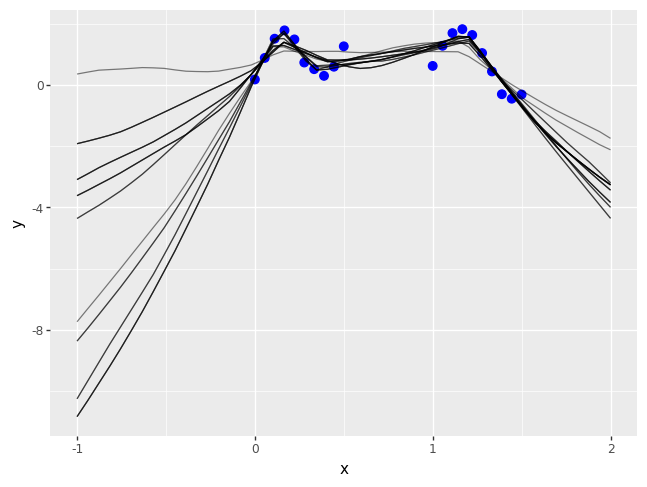

In [22]:
_

## Classification problem with 2 labels



In [34]:
#@title Create the classification experiment

# Generate dataset
dataset = classification_data.make_dataset()
num_classes = 2

# Logger
logger = TerminalLogger('supervised_regression')

# Create Ensemble ENN with a prior network
enn = networks.MLPEnsembleMatchedPrior(
    output_sizes=[50, 50, num_classes],
    dummy_input=next(dataset).x,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
)

# Cross entropy loss
loss_fn = losses.average_single_index_loss(
    single_loss=losses.XentLoss(num_classes),
    num_index_samples=FLAGS.num_index_samples
)

# Optimizer
optimizer = optax.adam(FLAGS.learning_rate)

# Aggregating different components of the experiment
experiment = supervised.Experiment(
    enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [35]:
# Train the experiment
experiment.train(FLAGS.num_batch)

In [33]:
# @title Plot the output
classification_data.colab_plots(experiment)

In [13]:
from typing import Optional
from enn.supervised import base as supervised_base
from enn import datasets as enn_datasets
from sklearn import datasets


def make_dataset(
    num_sample: int = 10, prob_swap: float = 0.0, seed: int = 0
) -> enn_datasets.ArrayBatchIterator:
    """Make a 2 moons dataset with num_sample per class and prob_swap label."""
    x, y = datasets.make_moons(2 * num_sample, noise=0.1, random_state=seed)

    # Swap the labels for data with prob_swap
    swaps = np.random.RandomState(seed).binomial(1, prob_swap, len(y))
    swap_locs = np.where(swaps)[0]
    y[swap_locs] = 1 - y[swap_locs]

    return utils.make_batch_iterator(enn_datasets.ArrayBatch(x=x, y=y))


def gen_2d_grid(plot_range: float) -> np.ndarray:
    """Generates a 2D grid for data in a certain_range."""
    data = []
    x_range = np.linspace(-plot_range, plot_range)
    for x1 in x_range:
        for x2 in x_range:
            data.append((x1, x2))
    return np.vstack(data)


def make_plot_data(
    experiment: supervised_base.BaseExperiment, num_sample: int
) -> pd.DataFrame:
    """Generate a classification plot with sampled predictions."""
    preds_x = gen_2d_grid(plot_range=3)

    data = []
    rng = hk.PRNGSequence(jax.random.PRNGKey(seed=0))
    for k in range(num_sample):
        net_out = experiment.predict(preds_x, key=next(rng))
        logits = networks.parse_net_output(net_out)
        preds_y = jax.nn.softmax(logits)
        data.append(
            pd.DataFrame(
                {
                    "x1": preds_x[:, 0],
                    "x2": preds_x[:, 1],
                    "label": preds_y[:, 1],
                    "sample": k,
                }
            )
        )
    return pd.concat(data)


def make_mean_plot(plot_df: pd.DataFrame, data_df: Optional[pd.DataFrame] = None):
    """Make a plot of 2D classification of the mean of the samples."""
    mean_df = plot_df.groupby(["x1", "x2"])["label"].mean().reset_index()
    if data_df is None:
        print("Error: data_df is required for plotting")
    p = (
        gg.ggplot()
        + gg.aes("x1", "x2", fill="label")
        + gg.geom_tile(data=mean_df, alpha=0.75)
        + gg.scale_fill_continuous(limits=[0, 1])
        + gg.geom_point(data=data_df, colour="black", size=5, stroke=2)
        + gg.ggtitle("Posterior mean from ENN")
        + gg.theme(figure_size=(12, 10), panel_spacing=0.2)
    )
    return p


def make_dataframe(
    dataset: Optional[enn_datasets.ArrayBatchIterator] = None,
) -> pd.DataFrame:
    dataset = dataset or make_dataset()
    batch = next(dataset)
    vals = np.hstack([batch.x, batch.y])
    return pd.DataFrame(vals, columns=["x1", "x2", "label"])


def make_sample_plot(plot_df: pd.DataFrame, data_df: Optional[pd.DataFrame] = None):
    """Make a plot of 2D classification samples over dataset."""
    if data_df is None:
        data_df = make_dataframe()
    p = (
        gg.ggplot()
        + gg.aes("x1", "x2", fill="label")
        + gg.geom_tile(data=plot_df, alpha=0.75)
        + gg.scale_fill_continuous(limits=[0, 1])
        + gg.geom_point(data=data_df, colour="black", size=5, stroke=2)
        + gg.facet_wrap("sample", labeller="label_both")
        + gg.ggtitle("Posterior samples from ENN")
        + gg.theme(figure_size=(20, 14), panel_spacing=0.2)
    )
    return p


def colab_plots(experiment: supervised_base.BaseExperiment):
    plot_df = make_plot_data(experiment, num_sample=100)
    dataframe = make_dataframe(experiment.dataset)
    p_mean = make_mean_plot(plot_df, dataframe)
    p_sample = make_sample_plot(plot_df[plot_df["sample"] < 12], dataframe)

    return p_sample, p_mean

In [14]:
p_sample, p_mean = colab_plots(experiment)

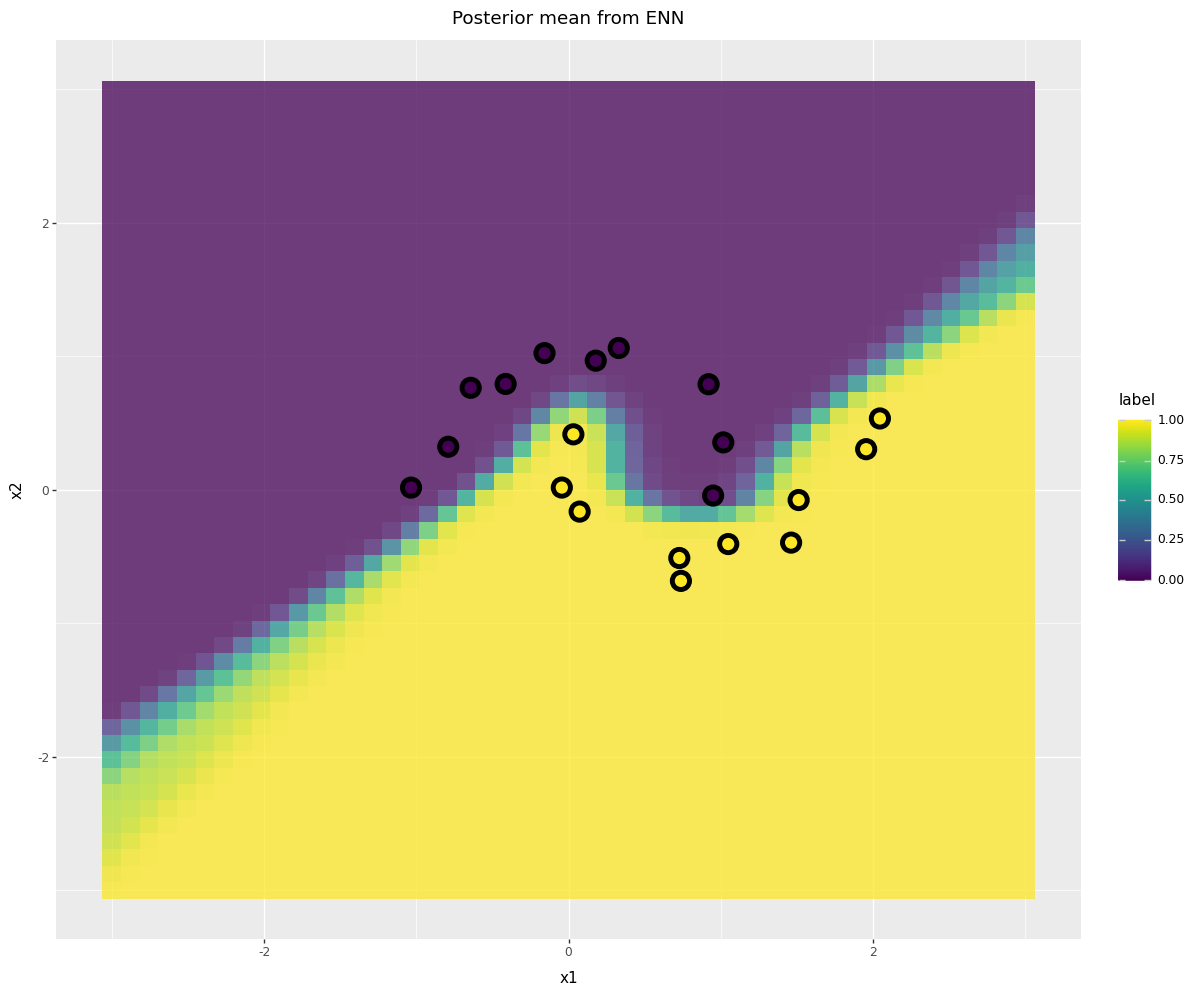

In [15]:
p_mean.draw()

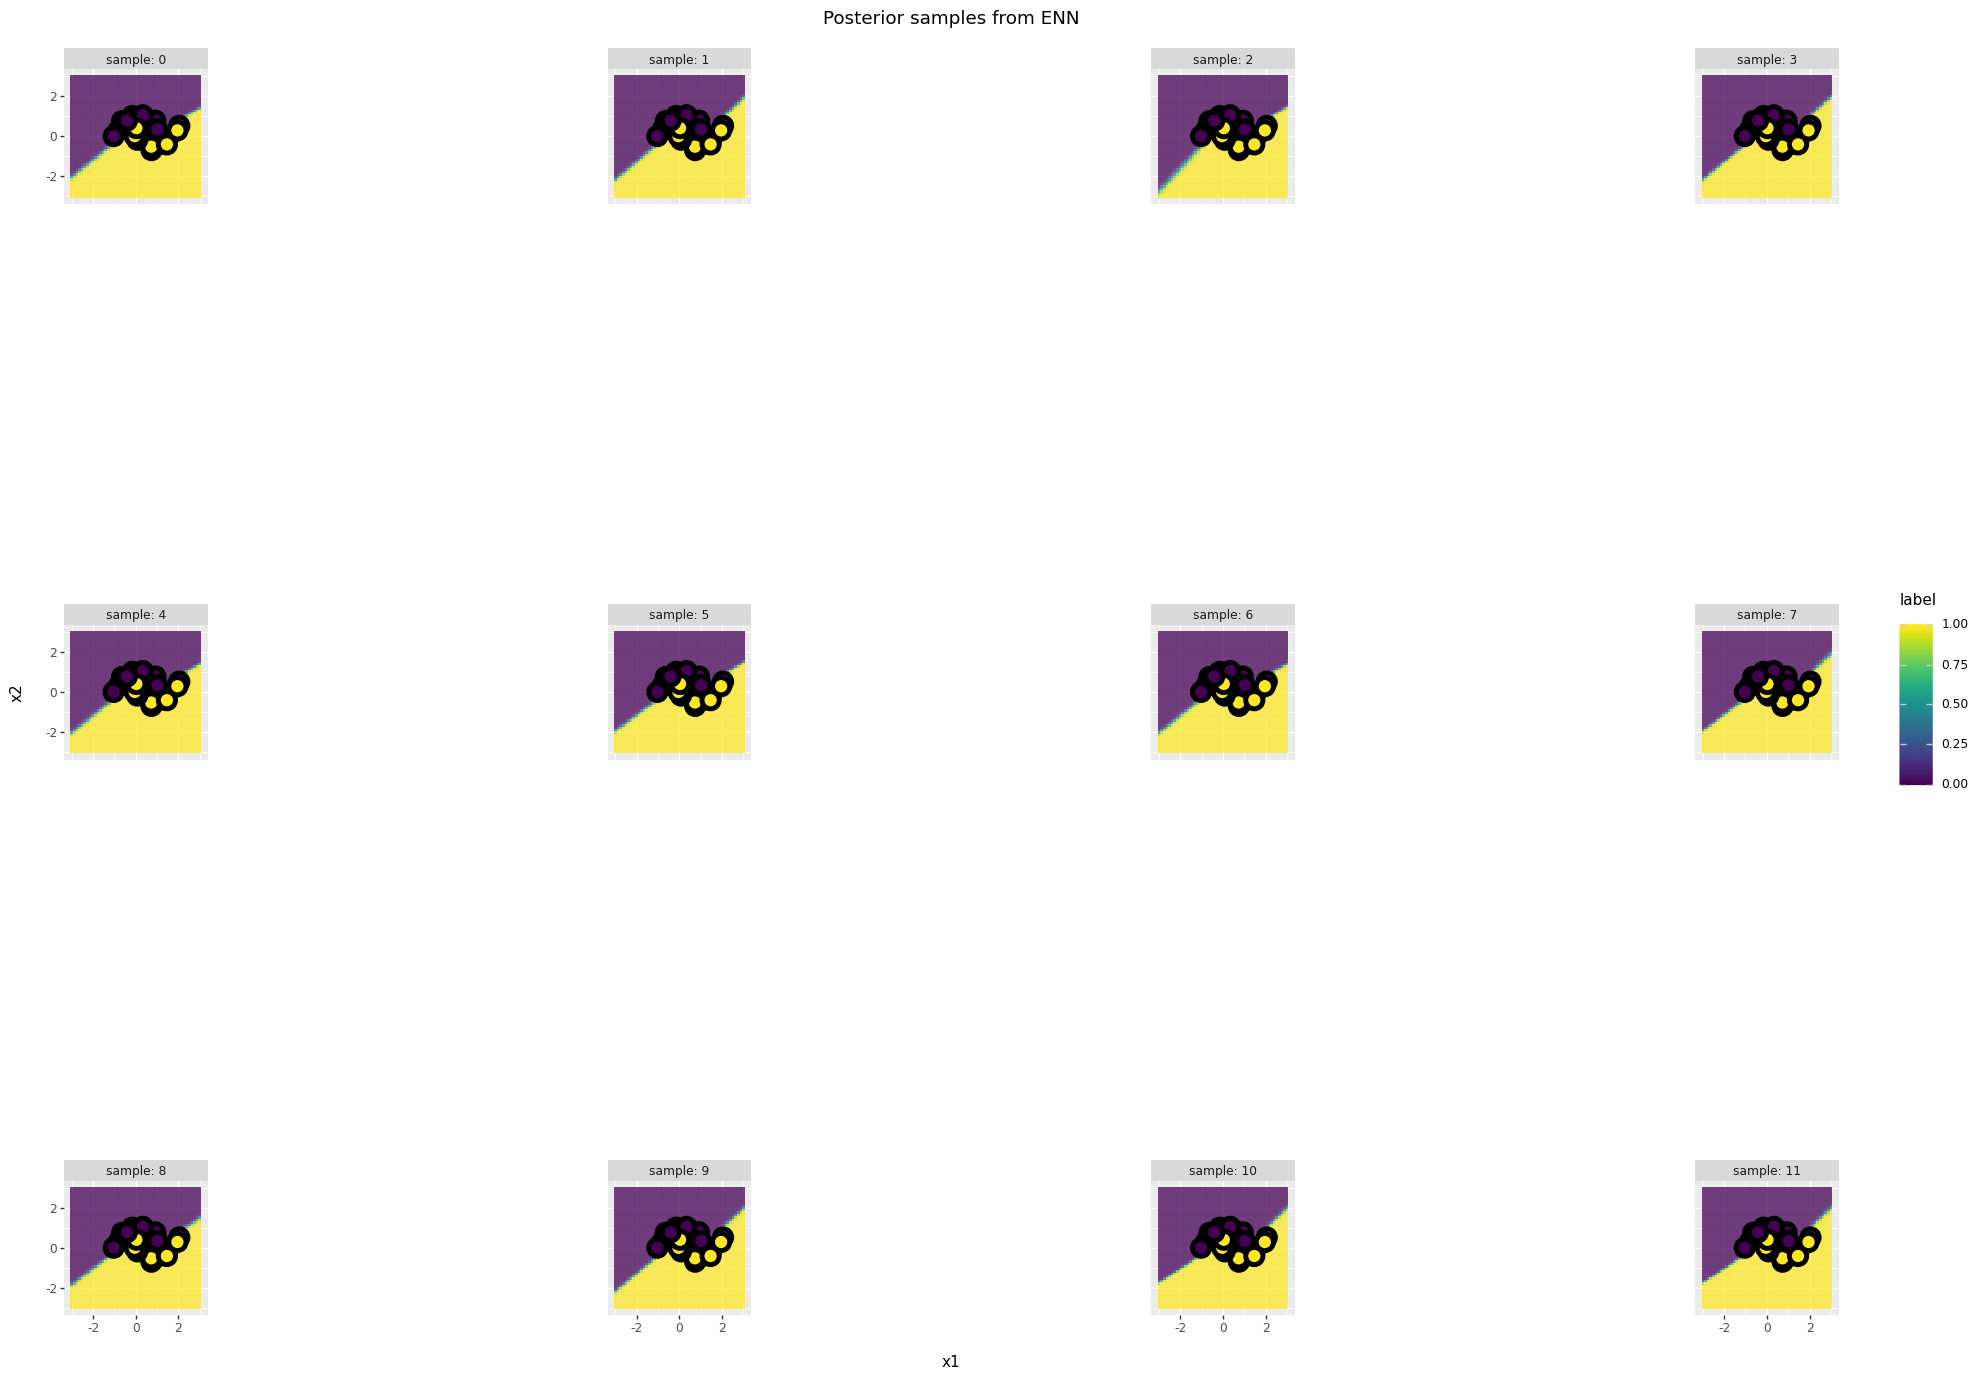

In [16]:
p_sample.draw()